## K-means++

In this notebook, we are going to implement [k-means++](https://en.wikipedia.org/wiki/K-means%2B%2B) algorithm with multiple initial sets. The original k-means++ algorithm will just sample one set of initial centroid points and iterate until the result converges. The only difference in this implementation is that we will sample `RUNS` sets of initial centroid points and update them in parallel. The procedure will finish when all centroid sets are converged.

In [1]:
### Definition of some global parameters.
K = 5  # Number of centroids
RUNS = 25  # Number of K-means runs that are executed in parallel. Equivalently, number of sets of initial points
RANDOM_SEED = 60295531
converge_dist = 0.1 # The K-means algorithm is terminated when the change in the location 
                    # of the centroids is smaller than 0.1

In [2]:
import numpy as np
import pickle
import sys
from numpy.linalg import norm
from matplotlib import pyplot as plt


def print_log(s):
    sys.stdout.write(s + "\n")
    sys.stdout.flush()


def parse_data(row):
    '''
    Parse each pandas row into a tuple of (station_name, feature_vec),`l
    where feature_vec is the concatenation of the projection vectors
    of TAVG, TRANGE, and SNWD.
    '''
    return (row[0],
            np.concatenate([row[1], row[2], row[3]]))


def compute_entropy(d):
    '''
    Compute the entropy given the frequency vector `d`
    '''
    d = np.array(d)
    d = 1.0 * d / d.sum()
    return -np.sum(d * np.log2(d))


def choice(p):
    '''
    Generates a random sample from [0, len(p)),
    where p[i] is the probability associated with i. 
    '''
    random = np.random.random()
    r = 0.0
    for idx in range(len(p)):
        r = r + p[idx]
        if r > random:
            return idx
    assert(False)


def kmeans_init(rdd, K, RUNS, seed):
    '''
    Select `RUNS` sets of initial points for `K`-means++
    '''
    # the `centers` variable is what we want to return
    n_data = rdd.count()
    shape = rdd.take(1)[0][1].shape[0]
    centers = np.zeros((RUNS, K, shape))

    def update_dist(vec, dist, k):
        new_dist = norm(vec - centers[:, k], axis=1)**2
        return np.min([dist, new_dist], axis=0)


    # The second element `dist` in the tuple below is the closest distance from
    # each data point to the selected points in the initial set, where `dist[i]`
    # is the closest distance to the points in the i-th initial set.
    data = rdd.map(lambda p: (p, [np.inf] * RUNS)) \
              .cache()

    # Collect the feature vectors of all data points beforehand, might be
    # useful in the following for-loop
    local_data = rdd.map(lambda (name, vec): vec).collect()

    # Randomly select the first point for every run of k-means++,
    # i.e. randomly select `RUNS` points and add it to the `centers` variable
    sample = [local_data[k] for k in np.random.randint(0, len(local_data), RUNS)]
    centers[:, 0] = sample

    for idx in range(K - 1):
        ##############################################################################
        # Insert your code here:
        ##############################################################################
        # In each iteration, you need to select one point for each set
        # of initial points (so select `RUNS` points in total).
        # For each data point x, let D_i(x) be the distance between x and
        # the nearest center that has already been added to the i-th set.
        # Choose a new data point for i-th set using a weighted probability
        # where point x is chosen with probability proportional to D_i(x)^2
        ##############################################################################
        
        #Repeat each data point by 25 times (for each RUN) to get 12140x25
        #Update distance
        data = data.map(lambda ((name,vec),dist): ((name,vec),update_dist(vec,dist,idx))).cache()
        
        #Calculate sum of D_i(x)^2
        d1 = data.map(lambda ((name,vec),dist): (1,dist))
        d2 = d1.reduceByKey(lambda x,y: np.sum([x,y], axis=0))
        total = d2.collect()[0][1]
        
        #Normalize each distance to get the probabilities and reshapte to 12140x25
        prob = data.map(lambda ((name,vec),dist): np.divide(dist,total)).collect()
        prob = np.reshape(prob,(len(local_data), RUNS))
        
        #K'th centroid for each run
        data_id = [choice(prob[:,i]) for i in xrange(RUNS)]
        sample = [local_data[i] for i in data_id]     
        centers[:, idx+1] = sample
        
    return centers


def get_closest(p, centers):
    '''
    Return the indices the nearest centroids of `p`.
    `centers` contains sets of centroids, where `centers[i]` is
    the i-th set of centroids.
    '''
    best = [0] * len(centers)
    closest = [np.inf] * len(centers)
    for idx in range(len(centers)):
        for j in range(len(centers[0])):
            temp_dist = norm(p - centers[idx][j])
            if temp_dist < closest[idx]:
                closest[idx] = temp_dist
                best[idx] = j
    return best


def kmeans(rdd, K, RUNS, converge_dist, seed):
    '''
    Run K-means++ algorithm on `rdd`, where `RUNS` is the number of
    initial sets to use.
    '''
    k_points = kmeans_init(rdd, K, RUNS, seed)
    print_log("Initialized.")
    temp_dist = 1.0

    iters = 0
    st = time.time()
    while temp_dist > converge_dist:
        ##############################################################################
        # INSERT YOUR CODE HERE
        ##############################################################################
        
        # Update all `RUNS` sets of centroids using standard k-means algorithm
        # Outline:
        #   - For each point x, select its nearest centroid in i-th centroids set
        #   - Average all points that are assigned to the same centroid
        #   - Update the centroid with the average of all points that are assigned to it
        
        # Insert your code here   

        #For each point x, select its nearest centroid in i-th centroids set
        #Format: ((RUN, nearest_centroid), point_coord)
        cen_rdd1 = rdd.flatMap(lambda p: 
                              [((indx,j),p[1]) for (indx,j) in enumerate(get_closest(p[1], k_points))])
        
        #Introduce 1 for count
        #Format: ((RUN, nearest_centroid), point, 1)
        cen_rdd2 = cen_rdd1.map(lambda ((run, k), pt): 
                                ((run, k), np.array([pt, 1])))
                                
        #Add all the distance and add 1's (count)    
        #Format: ((RUN, nearest_centroid), sum_points, count)
        cen_rdd3 = cen_rdd2.reduceByKey(lambda x,y: np.sum([x,y], axis=0))
 
        #Calculate mean distance for each run   
        #Format: ((RUN, nearest_centroid), mean_distance)
        cen_rdd4 = cen_rdd3.map(lambda ((run, k), p):
                                ((run, k), p[0]/p[1]))
        
        #Get dictionary of new_points
        new_points = cen_rdd4.collectAsMap()
        
        # You can modify this statement as long as `temp_dist` equals to
        # max( sum( l2_norm of the movement of j-th centroid in each centroids set ))
        ##############################################################################

#         temp_dist = np.max([
#                 np.sum([norm(k_points[idx][j] - new_points[(idx, j)]) for j in range(K)])
#                     for idx in range(RUNS)])

        temp_dist = np.max([
                np.sum([norm(k_points[idx][j] - new_points[(idx, j)]) for idx,j in new_points.keys()])
                            ])

        iters = iters + 1
        if iters % 5 == 0:
            print_log("Iteration %d max shift: %.2f (time: %.2f)" %
                      (iters, temp_dist, time.time() - st))
            st = time.time()

        # update old centroids
        # You modify this for-loop to meet your need
        for ((idx, j), p) in new_points.items():
            k_points[idx][j] = p

    return k_points

In [3]:
## Read data
data = pickle.load(open("/home/sadat/Desktop/UCSD_BigData_2016/Data/Weather/stations_projections.pickle", "rb"))
rdd = sc.parallelize([parse_data(row[1]) for row in data.iterrows()])
rdd.take(1)

[(u'USC00044534', array([  3.04796236e+03,   1.97434852e+03,   1.50560792e+02,
          -2.90363288e+03,  -2.36907268e+02,   1.47021791e+02,
           1.91503001e-01,   1.87262808e-01,  -4.01379553e-02]))]

In [4]:
# main code

import time

st = time.time()

np.random.seed(RANDOM_SEED)
centroids = kmeans(rdd, K, RUNS, converge_dist, np.random.randint(1000))
group = rdd.mapValues(lambda p: get_closest(p, centroids)) \
           .collect()

print "Time takes to converge:", time.time() - st

Initialized.
Iteration 5 max shift: 18811.76 (time: 21.72)
Iteration 10 max shift: 6234.56 (time: 21.37)
Iteration 15 max shift: 2291.96 (time: 21.44)
Iteration 20 max shift: 1285.12 (time: 21.35)
Iteration 25 max shift: 700.73 (time: 21.57)
Iteration 30 max shift: 455.04 (time: 21.34)
Iteration 35 max shift: 148.68 (time: 22.01)
Iteration 40 max shift: 101.45 (time: 27.06)
Iteration 45 max shift: 40.88 (time: 37.93)
Iteration 50 max shift: 16.89 (time: 21.13)
Iteration 55 max shift: 0.85 (time: 21.22)
Time takes to converge: 267.533921957


## Verify your results
Verify your results by computing the objective function of the k-means clustering problem.

In [5]:
def get_cost(rdd, centers):
    '''
    Compute the square of l2 norm from each data point in `rdd`
    to the centroids in `centers`
    '''
    def _get_cost(p, centers):
        best = [0] * len(centers)
        closest = [np.inf] * len(centers)
        for idx in range(len(centers)):
            for j in range(len(centers[0])):
                temp_dist = norm(p - centers[idx][j])
                if temp_dist < closest[idx]:
                    closest[idx] = temp_dist
                    best[idx] = j
        return np.array(closest)**2
    
    cost = rdd.map(lambda (name, v): _get_cost(v, centroids)).collect()
    return np.array(cost).sum(axis=0)

cost = get_cost(rdd, centroids)

In [6]:
log2 = np.log2

print log2(np.max(cost)), log2(np.min(cost)), log2(np.mean(cost))

33.8254902123 33.7575332525 33.7790236109


## Plot the increase of entropy after multiple runs of k-means++

In [7]:
entropy = []

for i in range(RUNS):
    count = {}
    for g, sig in group:
        _s = ','.join(map(str, sig[:(i + 1)]))
        count[_s] = count.get(_s, 0) + 1
    entropy.append(compute_entropy(count.values()))

**Note:** Remove this cell before submitting to PyBolt (PyBolt does not fully support matplotlib)

4.8799771938634473

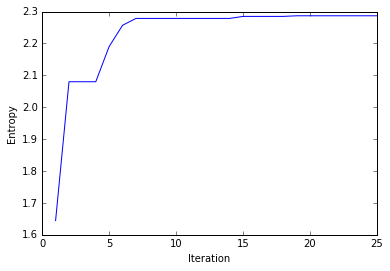

In [8]:
%matplotlib inline

plt.xlabel("Iteration")
plt.ylabel("Entropy")
plt.plot(range(1, RUNS + 1), entropy)
2**entropy[-1]

## Print the final results

In [9]:
print 'entropy=',entropy
best = np.argmin(cost)
print 'best_centers=',list(centroids[best])

entropy= [1.6445469704935676, 2.0800064512748428, 2.080006451274842, 2.0800064512748424, 2.1906681946052755, 2.2570115065383876, 2.2786597860645408, 2.2786597860645408, 2.2786597860645408, 2.2786597860645408, 2.2786597860645403, 2.2786597860645408, 2.2786597860645408, 2.2786597860645408, 2.2849509629282276, 2.2849509629282276, 2.2849509629282276, 2.2849509629282272, 2.286874405497795, 2.2868744054977945, 2.2868744054977945, 2.286874405497795, 2.2868744054977945, 2.286874405497795, 2.286874405497795]
best_centers= [array([ 2952.76608   ,  1933.02980077,    92.424188  , -2547.74851278,
         144.84123959,   154.0172669 ,    18.40817384,     7.84926361,
           5.11113863]), array([  428.4738994 ,  1807.58033164,    35.14799298, -2574.43476306,
        -180.39839191,   263.09089521,  6048.90511888,  -743.20856056,
         256.68319372]), array([ 1492.0570036 ,  1954.30230067,    94.48584365, -2567.99675086,
        -112.2682711 ,   152.28015089,   395.84574671,   131.09390181,
    